In [1]:
# %matplotlib tk

In [2]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l1_l2

In [ ]:
# データを読み込む
data_dir = '../Mining_DATA/Formatted_DATA/'

# csvファイルのリストを取得
csv_files = [f for f in os.listdir(data_dir) if f.endswith('.csv')]

# データを格納するための辞書
data_dict = {}

# 各csvファイルを読み込む
for file in csv_files:
    file_path = os.path.join(data_dir, file)
    df = pd.read_csv(file_path)
    data_dict[file] = df

# AAPL.csvを除外して説明変数を作成
appl_data = data_dict['AAPL.csv']

# # シフトする日数
# shift_days = 100

# # 'Date'カラム以外の全てのカラムをシフト
# appl_data.loc[:, appl_data.columns != 'Date'] = appl_data.loc[:, appl_data.columns != 'Date'].shift(-shift_days)

# # NaNを前方向補完で埋める
# appl_data.fillna(method='ffill', inplace=True)

# apple_dataをcsvとして保存
# appl_data.to_csv('apple_data_shifted.csv', index=False)

# 同じ日付で他のCSVのDataカラムを結びつける
merged_data = appl_data[['Date', 'Open']].copy()  # 目的変数

# AAPL.csv以外のCSVファイルのDataカラムを結びつける
for file, df in data_dict.items():
    if file != 'AAPL.csv':
        merged_data = pd.merge(merged_data, df[['Date', 'Open']], on='Date', suffixes=('', f'_{file[:-4]}'))
merged_data.to_csv('merged_data.csv', index=False)

merged_data.replace(0, np.nan, inplace=True)  # ゼロをNaNに変換
merged_data.ffill(inplace=True)  # 前方向補完
merged_data.bfill(inplace=True)  # 後方向補完

# 説明変数と目的変数に分ける
X = merged_data.drop(columns=['Date', 'Open'])  # 説明変数
y = merged_data['Open']  # 目的変数（AAPL.csvのOpen）

# データをtrainとtestに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# データを標準化
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# モデルの作成 (ニューラルネットワーク)
model = Sequential()
model.add(Dense(64, input_dim=X_train_scaled.shape[1], activation='leaky_relu'))
model.add(Dense(128, activation='leaky_relu'))
model.add(Dense(256, activation='leaky_relu'))
model.add(Dense(512, activation='leaky_relu'))
model.add(Dense(1024, activation='leaky_relu'))
model.add(Dense(2048, activation='leaky_relu'))
model.add(Dense(2048, activation='leaky_relu'))
model.add(Dense(2048, activation='leaky_relu'))
model.add(Dense(2048, activation='leaky_relu'))
model.add(Dense(2048, activation='leaky_relu'))
model.add(Dense(2048, activation='leaky_relu'))
model.add(Dense(1024, activation='leaky_relu'))
model.add(Dense(512, activation='leaky_relu'))
model.add(Dense(256, activation='leaky_relu'))
model.add(Dense(128, activation='leaky_relu'))
model.add(Dense(64, activation='leaky_relu'))
model.add(Dense(1))

# モデルのコンパイル
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error')

# 早期停止のコールバックを設定
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# モデルの学習
model.fit(
    X_train_scaled,
    y_train,
    epochs=200,
    batch_size=128,
    validation_split=0.1,
    callbacks=[early_stopping]  # コールバックを追加
)

# testデータで予測を実行
y_pred = model.predict(X_test_scaled)

# 精度評価
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')

Epoch 1/200
50/50 [==============================] - 2s 18ms/step - loss: 53.9408 - val_loss: 45.6871
Epoch 2/200
50/50 [==============================] - 1s 13ms/step - loss: 4.1379 - val_loss: 28.3395
Epoch 3/200
50/50 [==============================] - 1s 13ms/step - loss: 2.0485 - val_loss: 25.7581
Epoch 4/200
50/50 [==============================] - 1s 11ms/step - loss: 1.0467 - val_loss: 37.9413
Epoch 5/200
50/50 [==============================] - 1s 11ms/step - loss: 0.6014 - val_loss: 51.2443
Epoch 6/200
50/50 [==============================] - 1s 11ms/step - loss: 0.3981 - val_loss: 54.0222
Epoch 7/200
50/50 [==============================] - 1s 12ms/step - loss: 0.3084 - val_loss: 43.2374
Epoch 8/200
50/50 [==============================] - 1s 12ms/step - loss: 0.2776 - val_loss: 39.4959
Epoch 9/200
50/50 [==============================] - 1s 11ms/step - loss: 0.2456 - val_loss: 35.7620
Epoch 10/200
50/50 [==============================] - 1s 11ms/step - loss: 0.3547 - val_lo

In [ ]:
# データを読み込む
data_dir = '../Mining_DATA/Formatted_DATA/'

# AAPL.csvを読み込む
aapl_path = os.path.join(data_dir, 'AAPL.csv')
aapl_data = pd.read_csv(aapl_path)
aapl_data = aapl_data[['Date', 'Open']]

# AAPL.csv以外のcsvファイルのリストを取得
csv_files = [f for f in os.listdir(data_dir) if f.endswith('.csv') and f != 'AAPL.csv']

# データフレームのリスト
data_list = []

# 各CSVファイルを読み込み、DateとOpen列を選択
for file in csv_files:
    file_path = os.path.join(data_dir, file)
    df = pd.read_csv(file_path)
    df = df[['Date', 'Open']]
    # カラム名をユニークにするためにファイル名を追加
    df.rename(columns={'Open': f'Open_{file[:-4]}'}, inplace=True)
    data_list.append(df)

# 他の株のOpen値をマージ
merged_data = aapl_data
for df in data_list:
    merged_data = pd.merge(merged_data, df, on='Date', how='inner')

# 日付でソート
merged_data.sort_values('Date', inplace=True)

# 欠損値の処理
merged_data.dropna(inplace=True)
merged_data.to_csv('merged_data.csv', index=False)
# 特徴量と目的変数の設定
X = merged_data.drop(columns=['Date', 'Open'])
y = merged_data['Open']

# データをtrainとtestに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# データを標準化
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# モデルの作成 (ニューラルネットワーク)
model = Sequential()
model.add(Dense(64, input_dim=X_train_scaled.shape[1], activation='leaky_relu'))
model.add(Dense(128, activation='leaky_relu'))
model.add(Dense(256, activation='leaky_relu'))
model.add(Dense(512, activation='leaky_relu'))
model.add(Dense(1024, activation='leaky_relu'))
model.add(Dense(2048, activation='leaky_relu'))
model.add(Dense(2048, activation='leaky_relu'))
model.add(Dense(2048, activation='leaky_relu'))
model.add(Dense(2048, activation='leaky_relu'))
model.add(Dense(2048, activation='leaky_relu'))
model.add(Dense(2048, activation='leaky_relu'))
model.add(Dense(2048, activation='leaky_relu'))
model.add(Dense(2048, activation='leaky_relu'))
model.add(Dense(2048, activation='leaky_relu'))
model.add(Dense(1024, activation='leaky_relu'))
model.add(Dense(512, activation='leaky_relu'))
model.add(Dense(256, activation='leaky_relu'))
model.add(Dense(128, activation='leaky_relu'))
model.add(Dense(64, activation='leaky_relu'))
model.add(Dense(1))

# モデルのコンパイル
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error')

# 早期停止のコールバックを設定
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# モデルの学習
model.fit(
    X_train_scaled,
    y_train,
    epochs=200,
    batch_size=128,
    validation_split=0.1,
    callbacks=[early_stopping]  # コールバックを追加
)

# testデータで予測を実行
y_pred = model.predict(X_test_scaled)

# 精度評価
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')

Epoch 1/200
50/50 [==============================] - 2s 19ms/step - loss: 50.5886 - val_loss: 165.8294
Epoch 2/200
50/50 [==============================] - 1s 16ms/step - loss: 3.5291 - val_loss: 15.9591
Epoch 3/200
50/50 [==============================] - 1s 17ms/step - loss: 1.9471 - val_loss: 19.7904
Epoch 4/200
50/50 [==============================] - 1s 13ms/step - loss: 1.3183 - val_loss: 20.0266
Epoch 5/200
50/50 [==============================] - 1s 13ms/step - loss: 0.8843 - val_loss: 23.3586
Epoch 6/200
50/50 [==============================] - 1s 13ms/step - loss: 0.7779 - val_loss: 77.3607
Epoch 7/200
50/50 [==============================] - 1s 14ms/step - loss: 0.5791 - val_loss: 25.9606
Epoch 8/200
50/50 [==============================] - 1s 13ms/step - loss: 0.3690 - val_loss: 18.4589
Epoch 9/200
50/50 [==============================] - 1s 13ms/step - loss: 0.2572 - val_loss: 17.0225
Epoch 10/200
50/50 [==============================] - 1s 13ms/step - loss: 0.3449 - val_l

In [4]:
model.save('NN.h5')

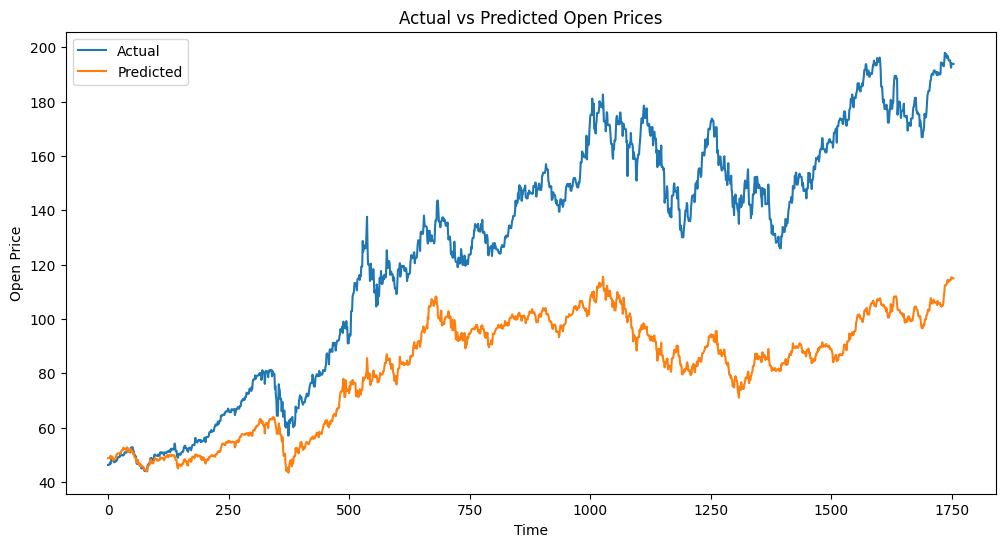

In [15]:
import matplotlib.pyplot as plt

# 予測結果と実際の値をプロット
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Open Price')
plt.title('Actual vs Predicted Open Prices')
plt.legend()
plt.show()

In [6]:
# import numpy as np
# import matplotlib.pyplot as plt

# # y_predを100日分後にずらす
# y_pred_shifted = np.roll(y_pred, -shift_days)

# # 予測結果と実際の値をプロット
# plt.figure(figsize=(12, 6))
# plt.plot(y_test.values, label='Actual')
# plt.plot(y_pred_shifted, label='Predicted (Shifted)')
# plt.xlabel('Time')
# plt.ylabel('Open Price')
# plt.title('Actual vs Predicted Open Prices (Shifted)')
# plt.legend()
# plt.show()